### Tracking Covid vaccine rollout in the US

Using data from the Johns Hopkins Centers for Civic Impact we can look at how vaccines are being rolled out across the US.
<br><br>
Let's start by importing our libraries and data

In [1]:
import pandas as pd
import matplotlib
matplotlib.rc('font',size=8)
import matplotlib.pyplot as plt
import numpy as np
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=pd.core.common.SettingWithCopyWarning)

In [2]:
# Get Vaccine data from Johns Hopkins Centers For Civic Impact github (raw csv data location)

# Original layout has been archived
# The original laid out doses of each type of vaccine, total doses administered, total people given first and second dose, etc.
#vaccine_data_location = "https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/raw_data/vaccine_data_us_state_timeline.csv"
archived_data_location = "https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/archive/vaccine_data_us_state_timeline.csv"

vaccine_data_location = "https://raw.githubusercontent.com/govex/COVID-19/master/data_tables/vaccine_data/us_data/time_series/vaccine_data_us_timeline.csv"
# New Layout doesn't differentiate between vaccine types


vf = pd.read_csv(vaccine_data_location,parse_dates=[1])
vf = vf.pivot_table(columns=['Province_State'],index='Date')
cols, states = vf.columns.levels

today = pd.datetime.today().strftime('%Y-%m-%d')
latest_data = vf.index.max().strftime('%Y-%m-%d')
print("Dashboard updated:\t{} \nLatest Data:\t\t{}".format(today,latest_data))

Dashboard updated:	2021-04-09 
Latest Data:		2021-04-09


In [3]:
# pandas import of state pops already exists in my support doc, hidden to protect local file paths
from covid_support import state_info
# Select AZ, CA, ME, NY, OR, TX, WA, WI
state_info = state_info.iloc[[0,1,7,8,9,12,14,15,16]]
state_info['c'] = ['hotpink','b','gold','g','r','c','m','y','k']
shortlist_states = state_info.loc[[1,9,12,14,15]]  # CA NY OR TX WA

#### Look at first and second doses
For the states that are tracking people innoculated with a first and second dose, let's look at the progression in terms of percent of population.
<br><br>
Note that for cases where the data is NA we use the last reported number of doses, i.e. we are not interpolating any progress, and jumps in the data will exist due to either the state's reporting, the data source, or perhaps the state really did give all of those doses in one day.
<br><br>
<b>Note:</b> It looks like the reporting of first/second doses is breaking, since there should not be more people with a second dose than with a first dose. I'll keep an eye and edit as necessary. In the meantime, look at the next plot of total shots.

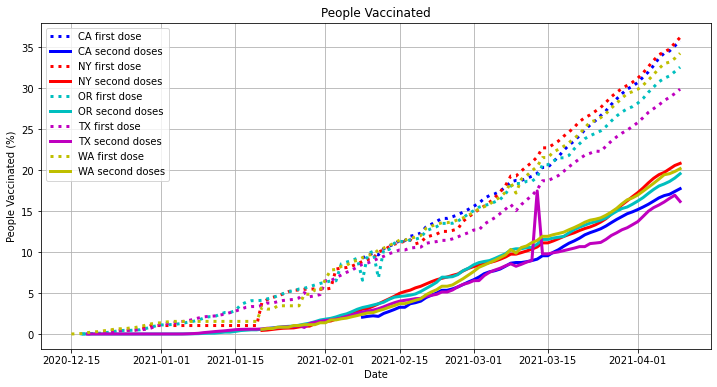

In [4]:
# People Vaccinated vs. Time

plt.figure(figsize=(12,6))
for i,r in shortlist_states.iterrows():
    vac_per_pop = (vf['Stage_One_Doses',r['State']]/(r['Pop']/1e2))#.fillna(method='ffill')
    second_vac_per_pop = (vf['Stage_Two_Doses',r['State']]/(r['Pop']/1e2))#.fillna(method='ffill')
    plt.plot(vf.index, vac_per_pop,linewidth=3, label=r['Short']+' first dose',linestyle='dotted',color=r['c'])
    plt.plot(vf.index, second_vac_per_pop,linewidth=3, label=r['Short']+' second doses',linestyle='solid',color=r['c'])

plt.title('People Vaccinated')
plt.ylabel('People Vaccinated (%)')
plt.xlabel('Date')
plt.legend()
plt.grid(which='both')

#### Total doses administered

Originally California wasn't reporting first/second doses in this data. Now they are, but we can still look at total doses noting that a total vaccination would be 200% of population, though this will also change as J&J single-dose vaccines become prevalent.
<br><br>
Also note that there will probably be cases where someone misses their second dose. If this means that someone then has to get 2 more doses, a full vaccination will look like more than 200% doses administered here.

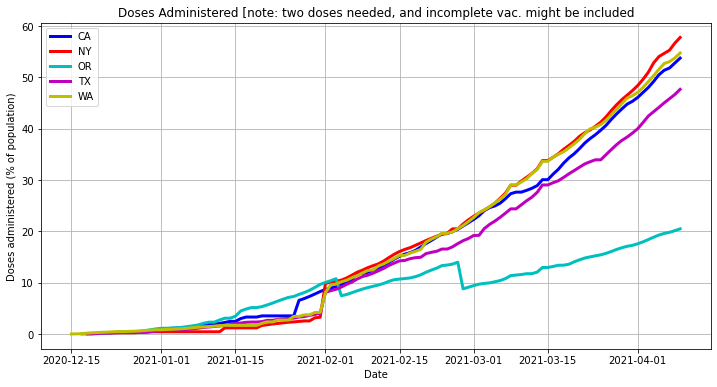

In [5]:
# Doses administered
plt.figure(figsize=(12,6))
for i,r in shortlist_states.iterrows():
    dose_per_pop = (vf['Doses_admin',r['State']]/(r['Pop']/1e2))
    plt.plot(vf.index, dose_per_pop,linewidth=3, label=r['Short'],linestyle='solid',color=r['c'])
plt.title('Doses Administered [note: two doses needed, and incomplete vac. might be included')
plt.ylabel('Doses administered (% of population)')
plt.xlabel('Date')
plt.legend()
plt.grid(which='both')

<b>ABOVE:</b> Oregon data is currently not being reported properly. Why?<br><br>

##### Let's look at the difference of allocated, shipped, and administered doses

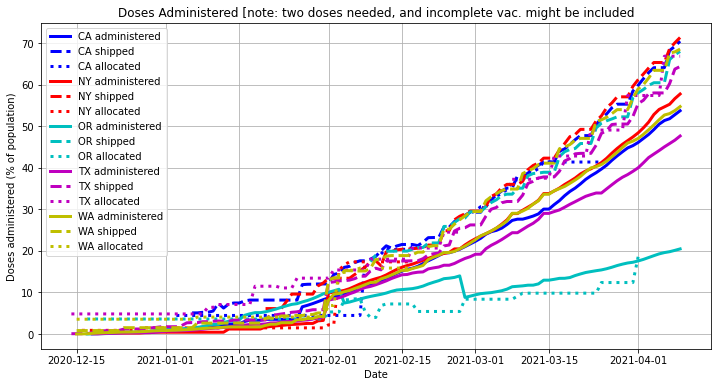

In [6]:
# Doses allocated, shipped, and administered
plt.figure(figsize=(12,6))
for i,r in shortlist_states.iterrows():
    admin = (vf['Doses_admin',r['State']]/(r['Pop']/1e2))
    alloc = (vf['Doses_alloc',r['State']]/(r['Pop']/1e2))
    ship = (vf['Doses_shipped',r['State']]/(r['Pop']/1e2))
    plt.plot(vf.index, admin,linewidth=3, label=r['Short']+' administered',linestyle='solid',color=r['c'])
    plt.plot(vf.index, ship,linewidth=3, label=r['Short']+' shipped',linestyle='dashed',color=r['c'])
    plt.plot(vf.index, alloc,linewidth=3, label=r['Short']+' allocated',linestyle='dotted',color=r['c'])
plt.title('Doses Administered [note: two doses needed, and incomplete vac. might be included')
plt.ylabel('Doses administered (% of population)')
plt.xlabel('Date')
plt.legend()
plt.grid(which='both')

<b>ABOVE:</b> Allocated isn't much different than shipped and so here is just crowding our graph. Also Oregon is still reporting useless data (given that the first/second dose data looks good).
#### Doses administered per day
Finally, let's look at the rate of vaccinations. Looking at the change in values of doses administered we can infer the number of doses adminstered for each day.
<br><br>
The scattered values will show raw values of change for each date, and then a line of 7d average will give us an idea of the weekly trends.
<br><br>
Data normalized to percent of population for comparison.

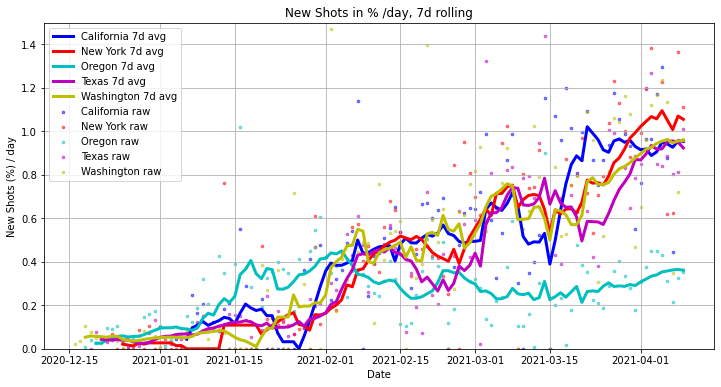

In [7]:
# New Shots per day normalized
plt.figure(figsize=(12,6))
for i,r in shortlist_states.iterrows():
    new_shots_per_pop_raw = (vf['Doses_admin',r['State']]/(r['Pop']/1e2)).diff()
    new_shots_per_pop_raw[new_shots_per_pop_raw < 0] = np.NaN # Set any negative shifts (OR data) to nan (not included)
    new_shots_per_pop_raw[new_shots_per_pop_raw > 1.5] = np.NaN # Seems unlikely given data as of 3/19, will be noise
    new_shots_per_pop = new_shots_per_pop_raw.rolling(7,min_periods=3).mean() #.fillna(0) # 7d avg will not include days of negative movement
    plt.scatter(vf.index,new_shots_per_pop_raw,color=r['c'],s=7,alpha=0.5,label=r['State']+' raw')
    plt.plot(vf.index, new_shots_per_pop,linewidth=3, label=r['State']+' 7d avg',color=r['c'])
plt.title('New Shots in % /day, 7d rolling')
plt.ylabel('New Shots (%) / day')
plt.xlabel('Date')
plt.ylim(0,1.5)
plt.legend()
plt.grid(which='both')

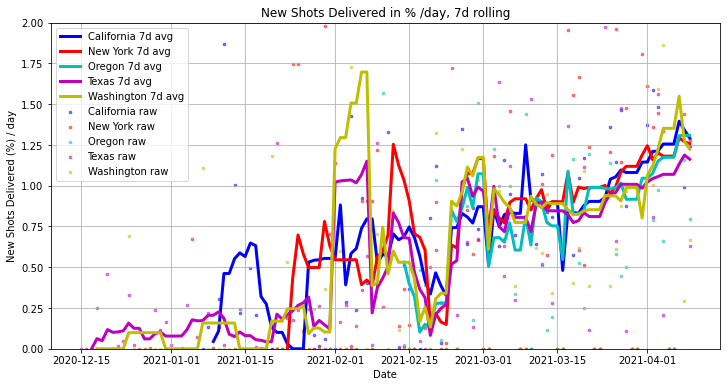

In [8]:
# New Shots Shipped per day normalized
# Can compare to above plot, is distribution limited by supply or distribution?
plt.figure(figsize=(12,6))
for i,r in shortlist_states.iterrows():
    new_ship_per_pop_raw = (vf['Doses_shipped',r['State']]/(r['Pop']/1e2)).diff()
    new_ship_per_pop_raw[new_ship_per_pop_raw < 0] = np.NaN # Set any negative shifts (OR data) to nan (not included)
    new_ship_per_pop = new_ship_per_pop_raw.rolling(7,min_periods=3).mean() #.fillna(0) # 7d avg will not include days of negative movement
    plt.scatter(vf.index,new_ship_per_pop_raw,color=r['c'],s=7,alpha=0.5,label=r['State']+' raw')
    plt.plot(vf.index, new_ship_per_pop,linewidth=3, label=r['State']+' 7d avg',color=r['c'])
plt.title('New Shots Delivered in % /day, 7d rolling')
plt.ylabel('New Shots Delivered (%) / day')
plt.xlabel('Date')
plt.ylim(0,2)
plt.legend()
plt.grid(which='both')